# Chapter: Recurrent Neural Networks


# Topic: Predicting engine failure usnig LSTM

In [5]:
# import required packages
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# settings for result reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

In [6]:
# read data
# training
train_df = pd.read_csv('PM_train.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True) # last two columns are blank
train_df.columns = ['EngineID', 'cycle', 'OPsetting1', 'OPsetting2', 'OPsetting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

# test 
test_df = pd.read_csv('PM_test.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['EngineID', 'cycle', 'OPsetting1', 'OPsetting2', 'OPsetting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

# actual RUL for each engine-id in the test data
truth_df = pd.read_csv('PM_truth.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True) # 2nd column is blank and thus, dropped
truth_df.columns = ['finalRUL'] # assigning column name as finalRUL
truth_df['EngineID'] = truth_df.index + 1 # adding new column EngineID

In [7]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##       generate RUL & binary output label for training and test dataset
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [8]:
# training dataset
maxCycle_df = pd.DataFrame(train_df.groupby('EngineID')['cycle'].max()).reset_index() 
maxCycle_df.columns = ['EngineID', 'maxEngineCycle'] # column maxEngineCycle stores total cycles for an engine until failure

train_df = train_df.merge(maxCycle_df, on=['EngineID'], how='left') 
train_df['engineRUL'] = train_df['maxEngineCycle'] - train_df['cycle'] # column engineRUL stores engine RUL at any given cycle
train_df.drop('maxEngineCycle', axis=1, inplace=True) # maxEngineCycle is not needed anymore

w1 = 30
train_df['binaryLabel'] = np.where(train_df['engineRUL'] <= w1, 1, 0 )
train_df.head()

,EngineID,cycle,OPsetting1,OPsetting2,OPsetting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,engineRUL,binaryLabel
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0


In [9]:
# compute maxEngineCycle for test data using data from test_df and truth_df
maxCycle_df = pd.DataFrame(test_df.groupby('EngineID')['cycle'].max()).reset_index()
maxCycle_df.columns = ['EngineID', 'maxEngineCycle']
truth_df['maxEngineCycle'] = maxCycle_df['maxEngineCycle'] + truth_df['finalRUL'] 
truth_df.drop('finalRUL', axis=1, inplace=True)

# generate engineRUL & binary label for test data
test_df = test_df.merge(truth_df, on=['EngineID'], how='left')
test_df['engineRUL'] = test_df['maxEngineCycle'] - test_df['cycle']
test_df.drop('maxEngineCycle', axis=1, inplace=True)

test_df['binaryLabel'] = np.where(test_df['engineRUL'] <= w1, 1, 0 )
test_df.head()

,EngineID,cycle,OPsetting1,OPsetting2,OPsetting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,engineRUL,binaryLabel
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,142,0
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,141,0
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,140,0
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,139,0
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,138,0


In [ ]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##                             scale training and test data
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [10]:
# training data: create temporary dataframe with columns to be scaled
all_cols = train_df.columns # get columns names
cols_to_scale = train_df.columns.difference(['EngineID','cycle','engineRUL','binaryLabel']) # returns all column labels except these specified
train_df_with_cols_to_scale = train_df[cols_to_scale]

# scale and rejoin with columns that were not scaled
scaler = StandardScaler()
scaled_train_df_with_cols_to_scale = pd.DataFrame(scaler.fit_transform(train_df_with_cols_to_scale), columns=cols_to_scale) # scalar transform returns a numpy array
train_df_scaled = train_df[['EngineID','cycle','engineRUL','binaryLabel']].join(scaled_train_df_with_cols_to_scale) # join back non-scaled columns
train_df_scaled = train_df_scaled.reindex(columns = all_cols) # same columns order as before

In [11]:
# test data: repeat above steps
all_cols = test_df.columns
test_df_with_cols_to_scale = test_df[cols_to_scale]
scaled_test_df_with_cols_to_scale = pd.DataFrame(scaler.transform(test_df_with_cols_to_scale), columns=cols_to_scale) 
test_df_scaled = test_df[['EngineID','cycle','engineRUL','binaryLabel']].join(scaled_test_df_with_cols_to_scale)
test_df_scaled = test_df_scaled.reindex(columns = all_cols) # same columns order as before

In [ ]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##            re-format training data into (samples, time steps, features) form
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [12]:
# define utility function
def generate_LSTM_samples(engine_df, nSequenceSteps):
    """
        This function generates list of LSTM samples (numpy arrays of size (nSequenceSteps, 24) each) for LSTM input
        and list of output labels for LSTM
    """
    engine_X_train_sequence = []
    engine_y_train_sequence = []
    engine_data = engine_df.values # converting to numpy
    
    for sample in range(nSequenceSteps, engine_data.shape[0]):
        engine_X_train_sequence.append(engine_data[sample-nSequenceSteps:sample,:-1]) # last column is output label
        engine_y_train_sequence.append(engine_data[sample,-1])
    
    return engine_X_train_sequence, engine_y_train_sequence

In [13]:
nSequenceSteps = 50 # number of cycles in a sequence
X_train_sequence = []
y_train_sequence = []

# generate sequence samples
for engineID in train_df_scaled['EngineID'].unique():
    engine_df = train_df_scaled[train_df_scaled['EngineID'] == engineID]
    engine_df = engine_df[['OPsetting1', 'OPsetting2', 'OPsetting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                           's15', 's16', 's17', 's18', 's19', 's20', 's21', 'binaryLabel']]
    engine_X_train_sequence, engine_y_train_sequence = generate_LSTM_samples(engine_df, nSequenceSteps)
    
    X_train_sequence = X_train_sequence + engine_X_train_sequence # adding samples to the common list
    y_train_sequence = y_train_sequence + engine_y_train_sequence

X_train_sequence, y_train_sequence = np.array(X_train_sequence), np.array(y_train_sequence) # convert list of (time steps, features) array into (samples, time steps, features) array

Text(0.5, 0, 'category')

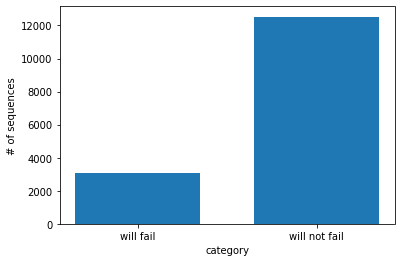

In [14]:
#bar plot y_train_sequence
plt.figure()
plt.bar(['will fail', 'will not fail'], [np.sum(y_train_sequence), np.sum(y_train_sequence==0)], width = 0.7)
plt.ylabel('# of sequences')
plt.xlabel('category')  

In [15]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##                       define and fit LSTM model
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# import ANN packages
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# define model
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(nSequenceSteps, 24)))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 100)           50000     
_________________________________________________________________
dropout (Dropout)            (None, 50, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 80,251
Trainable params: 80,251
Non-trainable params: 0
_________________________________________________________________


In [16]:
# compile model
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [17]:
# create stratified validation split
from sklearn.model_selection import train_test_split
X_est_sequence, X_val_sequence, y_est_sequence, y_val_sequence = train_test_split(X_train_sequence, y_train_sequence, stratify=y_train_sequence, test_size = 0.3, random_state = 100)

# confirm
print('Fraction of failures in estimation dataset: ', np.mean(y_est_sequence))
print('Fraction of failures in validation dataset: ', np.mean(y_val_sequence))

Fraction of failures in estimation dataset:  0.19833653230966092
Fraction of failures in validation dataset:  0.19829424307036247


In [18]:
# fit model with early stopping
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_est_sequence, y_est_sequence, epochs=100, batch_size=250, validation_data=(X_val_sequence, y_val_sequence), callbacks=[es])

Epoch 1/100
44/44 [==============================] - 6s 140ms/step - loss: 0.2245 - accuracy: 0.9112 - val_loss: 0.1011 - val_accuracy: 0.9665
Epoch 2/100
44/44 [==============================] - 5s 121ms/step - loss: 0.0867 - accuracy: 0.9660 - val_loss: 0.0956 - val_accuracy: 0.9603
Epoch 3/100
44/44 [==============================] - 5s 122ms/step - loss: 0.0805 - accuracy: 0.9663 - val_loss: 0.0678 - val_accuracy: 0.9731
Epoch 4/100
44/44 [==============================] - 5s 120ms/step - loss: 0.0637 - accuracy: 0.9742 - val_loss: 0.0623 - val_accuracy: 0.9738
Epoch 5/100
44/44 [==============================] - 5s 116ms/step - loss: 0.0586 - accuracy: 0.9754 - val_loss: 0.0482 - val_accuracy: 0.9793
Epoch 6/100
44/44 [==============================] - 5s 121ms/step - loss: 0.0534 - accuracy: 0.9777 - val_loss: 0.0578 - val_accuracy: 0.9746
Epoch 7/100
44/44 [==============================] - 5s 121ms/step - loss: 0.0460 - accuracy: 0.9799 - val_loss: 0.0464 - val_accuracy: 0.9808

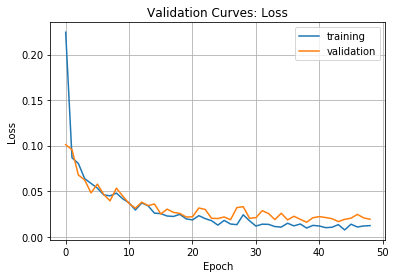

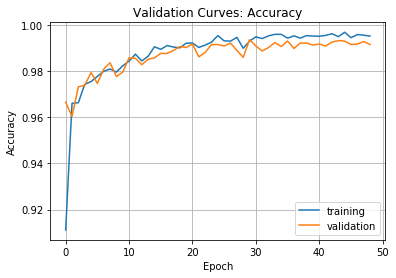

In [19]:
# plot validation curve
plt.figure()
plt.title('Validation Curves: Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.title('Validation Curves: Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='training')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.grid()
plt.show()

In [20]:
# confusion matrix
from sklearn.metrics import confusion_matrix

y_train_sequence_pred = model.predict(X_train_sequence) > 0.5 # converting probabilities to binaryLabel
conf_matrix = confusion_matrix(y_train_sequence, y_train_sequence_pred)

In [ ]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##                         evaluate model on test data
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [21]:
# input/output test sequences (only the last sequence is used to predict failure)
X_test_sequence = []
y_test_sequence = []

for engineID in test_df_scaled['EngineID'].unique():
    engine_df = test_df_scaled[test_df_scaled['EngineID'] == engineID]
    
    if engine_df.shape[0] >= nSequenceSteps:
        engine_df = engine_df[['OPsetting1', 'OPsetting2', 'OPsetting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                           's15', 's16', 's17', 's18', 's19', 's20', 's21', 'binaryLabel']].values
        X_test_sequence.append(engine_df[-nSequenceSteps:,:-1])
        y_test_sequence.append(engine_df[-1,-1])
        
X_test_sequence, y_test_sequence = np.array(X_test_sequence), np.array(y_test_sequence)

Text(0.5, 7.5, 'Predicted Class')

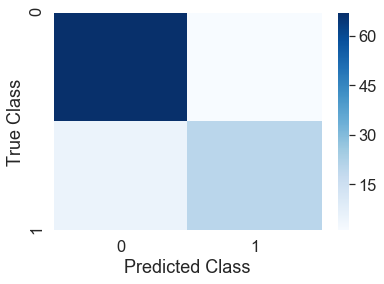

In [26]:
# confusion matrix for test data
import seaborn as sn

y_test_sequence_pred = model.predict(X_test_sequence) > 0.5 # converting probabilities to binaryLabel
conf_matrix_test = confusion_matrix(y_test_sequence, y_test_sequence_pred)

# plot
sn.set(font_scale=1.5) # for label size
sn.heatmap(conf_matrix_test, fmt='.0f', cmap='Blues')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

In [23]:
# compute precision, recall, and accuracy
from sklearn.metrics import recall_score, precision_score, accuracy_score

test_accuracy = accuracy_score(y_test_sequence, y_test_sequence_pred)
test_precision = precision_score(y_test_sequence, y_test_sequence_pred)
test_recall = recall_score(y_test_sequence, y_test_sequence_pred)
test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall)

testPerformance_df = pd.DataFrame([[test_accuracy, test_precision, test_recall, test_f1]],
                         columns = ['Accuracy', 'Precision', 'Recall', 'F1-score'],
                         index = ['LSTM model'])
testPerformance_df

,Accuracy,Precision,Recall,F1-score
LSTM model,0.935484,0.952381,0.8,0.869565
